## Extinction Corrected Effective Temperature
### To run this notebook, please [follow the instructions](https://lasair-lsst.readthedocs.io/en/main/core_functions/python-notebooks.html) or else it won`t work.
The instructions are at https://lasair-lsst.readthedocs.io/en/main/core_functions/python-notebooks.html

The LSST cadence includes a lot of "pairs", meaning the same object imaged 
in different bandpasses about 30 minutes apart. See https://survey-strategy.lsst.io/baseline/wfd.html
This is an opportunity to get a colour measurement of the object, assuming that intrinsic
brightness has not changed in 30 minutes.
The pair of bandpasses are not just g+r but can be several combinations, see `PAIRS` below,
where the numbers index the LSST bands, so (0,2) means u+r bands.

Because the pair of bands vary, it is difficult to understand the meaning 
-- how is a u-r colour different from a g-r colour? Therefore Lasair would like to compute an
effective temperature from the two fluxes, to serve as a universal measure. If you want blue, filter out
the low temperatures, rather than having different criteria for different pairs of bandpasses.
To make this temperature even more useful, we make extinction correction first.

The executive summary:
- If g-r is 0.99, with no extinction, then the temperature is 3,620K.
- If g-r is 0.99 and very dusty, then the temperature is 7,740 K.

In [1]:
# The LSST bands, wavelength in microns
WL    = [0.380,     0.500,     0.620,     0.740,     0.880,     1.000, ]
BANDS = ['u',       'g',       'r'  ,     'i'  ,     'z'  ,     'y'    ]

In [2]:
# the pairs strategy
# u+g, u+r, g+r, r+i,  i+z,  z+y
# from https://survey-strategy.lsst.io/baseline/wfd.html
PAIRS = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]

These coefficients are for the extinction correction. 
For the g-filter, for example, an E(B-V) value of 0.5 
would increase the g magnitude number by 0.5*3.237 = 1.618 mags,
equivalently decrease the flux by a factor of 10^(1.618/2.5) = 4.43.

These colour corrections are from Table 6 of 
[Schlafly and Finkbeiner](https://iopscience.iop.org/article/10.1088/0004-637X/737/2/103) with RV=3.1

In [3]:
# Multiplier for EBV for magnitude correction
EXTCOEF   = [4.145,    3.237,    2.273,    1.684,    1.323,    1.088]

You need to install the `dustmaps` package

In [4]:
import sys, math
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord

# Uncomment this to install the dustmaps package
#!/usr/bin/pip3 install dustmaps
from dustmaps.config import config

# Set this to where you want the two 64 Mbyte dustmap files
config['data_dir'] = '/Users/rwillia5/Desktop'

# Uncomment the following to download the SFD dustmap
# dustmaps.sfd.fetch()

from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
sfd = SFDQuery()

### Flux and magnitude
LSST is all flux, but people like colour as magnitude differences. Here are the converters.

In [5]:
def mag2flux(mag):
    # flux in nanoJ
    flux =  math.pow(10, (31.4 - mag)/2.5)
    return flux
def flux2mag(flux):
    # flux in nanoJ
    mag = 31.4 - 2.5*math.log10(flux)
    return mag

### Blackbody spectrum
This formula is "per Hertz" to match up with the definition of Jansky.
The number 'hck' is planck * speed of light / boltzmann, with temperature in kilokelvin and wavelength in microns.
There is also the derivative with respect to T so that we can do a Newton solver.
The commented out code shows that the derivative formula is numerically correct.

In [6]:
def blackbody(wl, T):
    hck = 14.387
    q = math.exp(hck/(wl*T))
    return math.pow(wl, -3.0) /(q - 1)

def dblackbody(wl, T):
    hck = 14.387
    q = math.exp(hck/(wl*T))
    return math.pow(wl, -3.0) * (hck/(wl*T*T)) * q/((q-1)*(q-1))
    
# show that the derivative formula is right
#T = 8
#wl = 0.7
#dT = 0.0001
#d1 = (blackbody(wl, T+dT) - blackbody(wl, T))/dT
#d2 = dblackbody(wl, T)
#print(d1, d2)

### Effective temperature
In the following plot, assume we have simultaneous detections in the u and r bands, 
with the u flux 0.5 times the r flux, equivalently the u-r is 0.75 mags.
We say the effective temperature for this flux ratio is 6.88 kK = 6,880 Kelvin

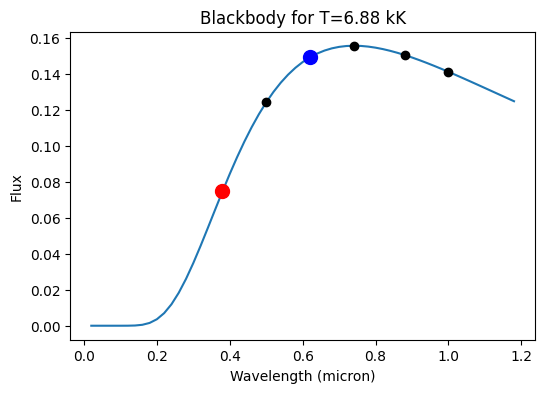

rflux/uflux at T=6.88 is 0.500


In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(1, 1, 1)

temp = 6.88  # already know this is the answer!
wl = []
flux = []
for iwl in range(1,60):
    w = 0.02*iwl
    wl.append(w)
    flux.append(blackbody(w, temp))
ax.plot(wl, flux)

for i in range(len(WL)):
    b = blackbody(WL[i], temp)
    ax.plot(WL[i], b, 'ko')
b0 = blackbody(WL[0], temp)
ax.plot(WL[0], b0, 'ro', markersize=10)   # red spot at 0.380 micron
b2 = blackbody(WL[2], temp)
ax.plot(WL[2], b2, 'bo', markersize=10)   # blue spot at 0.620 micron

plt.title('Blackbody for T=%.2f kK' % temp)
plt.xlabel("Wavelength (micron)")
plt.ylabel("Flux")
plt.show()

# if we chose the temperature correctly, should get flux ratio 0.5
print('rflux/uflux at T=%.2f is %.3f' % (temp, b0/b2))

### Newton solver
Given a flux ratio `fluxrat` and two wavelengths `wl1` and `wl2`, we want to solve for the temperature `T`:
```
blackbody(wl1, T)/blackbody(wl2, T) = fluxrat

--> blackbody(wl1, T) - fluxrat* blackbody(wl2, T) = 0
```
However the flux ratio is first modified because of extinction, as the different 
wavelengths are extincted differently. See `EXTCOEF` above. First we make a magnitude change, 
then convert that to a multiplier on the flux ratio.

In [8]:
def solve_for_temperature(fluxrat, i1, i2, ebv=0):
    
    # modify fluxrat for extinction
    mag_corr = ebv*(EXTCOEF[i1] - EXTCOEF[i2])
    fluxrat_corr = fluxrat*math.pow(10, mag_corr/2.5)
    
    T = 12  # guess 12,000 kelvin
    wl1 = WL[i1]
    wl2 = WL[i2]
    for i in range(50):
        try:
            fr  =  blackbody(wl1, T) - fluxrat_corr* blackbody(wl2, T)
            dfr = dblackbody(wl1, T) - fluxrat_corr*dblackbody(wl2, T)
        except:
            return None
        dT = fr/dfr
        T = T - dT
        if abs(dT) < 0.001: return T # convergence
            
        if T < 0: return None  # not interested in negative temperatures
    return None

### Everything below is presentation

In [9]:
def printline(fluxrat, i1, i2, ebv):
    magdiff = -2.5*math.log10(fluxrat)
    print('%5.2f   %5.2f |' % (fluxrat, magdiff), end='')
    for (i1,i2) in PAIRS:
        s = solve_for_temperature(fluxrat, i1, i2, ebv)
        if s:
            print('%8.2f' % s, end='')
        else:
            print('     -- ', end='')
    print()

In [10]:
def make_table(ebv):
    print('E(B-V) = %.3f' % ebv)
    print('Temperature in kK for given flux ratio in given bands')
    print('Flux rat| m-m |    ', end='')
    for (i1,i2) in PAIRS:
        print('%s-%s     ' % (BANDS[i1], BANDS[i2]), end='')
    print()

    for i in range(10):
        fluxrat = 0.02*i + 0.01
        printline(fluxrat, i1, i2, ebv)
    for i in range(20):
        fluxrat = 0.1*i + 0.2
        printline(fluxrat, i1, i2, ebv)   

### Clear and dusty
First we make a run with a clear sky, far from milky way, E(B-V)=0.027.
The we make a run with a dusty sky, near the galactic centre, E(B-V)=0.919.

In [11]:
sfd = SFDQuery()

# clear view with zero extinction
ebv = 0.0
make_table(ebv)

print('================')

# dusty
ra   = 270
decl = -30
c = SkyCoord(ra, decl, unit="deg", frame='icrs')
ebv = float(sfd(c))
make_table(ebv)

E(B-V) = 0.000
Temperature in kK for given flux ratio in given bands
Flux rat| m-m |    u-g     u-r     g-r     r-i     i-z     z-y     
 0.01    5.00 |    1.67    2.41    1.06    0.73    0.60    0.39
 0.03    3.81 |    2.10    2.95    1.34    0.93    0.77    0.50
 0.05    3.25 |    2.38    3.28    1.53    1.07    0.88    0.58
 0.07    2.89 |    2.61    3.55    1.69    1.18    0.97    0.64
 0.09    2.61 |    2.81    3.78    1.82    1.28    1.06    0.70
 0.11    2.40 |    3.00    3.99    1.95    1.37    1.13    0.76
 0.13    2.22 |    3.17    4.18    2.07    1.46    1.21    0.81
 0.15    2.06 |    3.34    4.36    2.19    1.55    1.28    0.86
 0.17    1.92 |    3.50    4.53    2.30    1.63    1.35    0.91
 0.19    1.80 |    3.66    4.69    2.42    1.72    1.42    0.96
 0.20    1.75 |    3.74    4.77    2.47    1.76    1.45    0.98
 0.30    1.31 |    4.49    5.51    3.01    2.17    1.79    1.24
 0.40    0.99 |    5.23    6.20    3.57    2.60    2.15    1.51
 0.50    0.75 |    6.02    6.88